In [42]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.inspection import permutation_importance
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split

In [3]:
df   = pd.read_csv('dataset-train.csv')
df_s = pd.read_csv('dataset-test.csv')  #This dataset contains part of full dataset

In [4]:
df.head()

,ItemLastMill,PackingType,attrCNC,Construction,DecVeneer,Drawing,EdgeColor,EdgeProc,Edges,FilmColor,...,Productname008,Model008,Code008,CustomerAccount,MonthNum,Qty,Thickness,Width,PlyLength,GrossActualKg
0,K,KTB0CP,N,-,-/-,-,d.br.,-,standard,d.br./d.br.,...,-,-,-,-,1,18,18.0,2750,1250,838.003
1,F,FKB0CH,N,30_spec-14,-/-,-,-,-,soft,d.br./d.br.,...,-,-,-,-,1,20,30.0,2550,1560,1710.000
2,F,FKB0CH,N,30_spec-14,-/-,-,-,-,soft,d.br./d.br.,...,-,-,-,-,1,20,30.0,2550,1560,1714.000
3,F,FKB0CH,N,30_spec-14,-/-,-,-,-,soft,d.br./d.br.,...,-,-,-,-,1,20,30.0,2550,1560,1674.000
4,F,FTB0VP,N,-,-/-,-,d.br.,-,standard,d.br./d.br.,...,-,-,-,D000861,1,35,21.0,2500,1500,1992.000


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217720 entries, 0 to 217719
Data columns (total 40 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   ItemLastMill     217720 non-null  object 
 1   PackingType      217720 non-null  object 
 2   attrCNC          217720 non-null  object 
 3   Construction     217720 non-null  object 
 4   DecVeneer        217720 non-null  object 
 5   Drawing          217720 non-null  object 
 6   EdgeColor        217720 non-null  object 
 7   EdgeProc         217720 non-null  object 
 8   Edges            217720 non-null  object 
 9   FilmColor        217720 non-null  object 
 10  FilmLogo         217720 non-null  object 
 11  FilmMat          217720 non-null  object 
 12  FilmWeight       217720 non-null  object 
 13  Finishing        217720 non-null  object 
 14  FinishingColor   217720 non-null  object 
 15  FinishingType    217720 non-null  object 
 16  Glossiness       217720 non-null  obje

In [6]:
f_float = ['Thickness']
f_label = ['GrossActualKg']
f_int   = ['MonthNum', 'Qty', 'Width','PlyLength']


In [7]:
#Column selector and transformer will be used later in code

col_selector = make_column_selector(dtype_include=object)
col_transformer = make_column_transformer(
    (StandardScaler(), f_int + f_float),
    (OneHotEncoder(sparse_output = False, drop = 'if_binary', handle_unknown='ignore'), col_selector), 
    remainder = 'drop'
)


### Train/Test dataset prepare

In [12]:
#Prepare train and test dataset 

X = df.drop(f_label, axis=1).copy()
y = df[f_label]

X_s = df_s.drop(f_label, axis=1).copy()
y_s = df_s[f_label]

X_s_train, X_s_test, y_s_train, y_s_test = train_test_split(X_s, y_s, random_state=17)

In [13]:
#This code tries to fix the problem with new categorical feature values in test dataset which are not present in training dataset.
for col in X_s.select_dtypes(include=['object','category']).columns:
    train_categories = set(X_s_train[col].unique())
    test_categories  = set(X_s_test[col].unique())
    missing_in_train = test_categories - train_categories

    if missing_in_train:
        print(f"Warning: {col} has categories in test but not in train: {missing_in_train}")

        for cat in missing_in_train:
            mask = X_s_test[col]==cat
            indices = X_s_test[mask].index[:1]

            X_s_train = pd.concat([X_s_train, X_s_test.loc[indices]])
            y_s_train = pd.concat([y_s_train, y_s_test.loc[indices]])

            X_s_test = X_s_test.drop(indices)
            y_s_test = y_s_test.drop(indices)

print('All done')

All done


### Categorial feature value distribution

In [8]:
#Get basic value information for each column

for col in df.columns:
    print("")
    print(df[col].value_counts(dropna=False))



ItemLastMill
F    96928
V    69520
H    31432
T    18563
L     1273
K        4
Name: count, dtype: int64

PackingType
VTB0VP      45260
FTB0VP      31011
FKB0CT      12501
FTB0CP      10799
HBP0VP      10119
            ...  
FTB0CM          1
FTBPCP          1
TB20SP15        1
LTB5KP          1
HBL0AP          1
Name: count, Length: 153, dtype: int64

attrCNC
N    193811
Y     23909
Name: count, dtype: int64

Construction
-              184582
30_spec-14      10485
28_spec-1        5542
16_(12-pls)      3918
14_(10-pls)      2637
30_spec-13       2031
15_spec-12       1221
18_spec-12       1102
35_spec-12       1010
12_spec-1         898
12_spec-12        635
41_spec-2         566
22_(16-pls)       445
41_spec-1         442
19_(14-pls)       408
10_(8-pls)        245
28_(20-pls)       204
8_(6-pls)         177
45_(33-pls)       156
30_spec-20        139
30_spec-1          89
5_(4-pls)          79
28_spec-12         67
21_spec-13         61
44_spec-1          58
35_spec-14         57

### Correlation matrix of number features

In [10]:
corr_matrix = df[f_float+f_int+f_label].corr()
corr_matrix

,Thickness,MonthNum,Qty,Width,PlyLength,GrossActualKg
Thickness,1.000000,-0.019429,-0.208753,0.093740,0.173855,0.030175
MonthNum,-0.019429,1.000000,-0.001417,0.017301,0.033352,0.023449
Qty,-0.208753,-0.001417,1.000000,0.011603,-0.020192,0.149104
Width,0.093740,0.017301,0.011603,1.000000,0.443390,0.591734
PlyLength,0.173855,0.033352,-0.020192,0.443390,1.000000,0.525704
GrossActualKg,0.030175,0.023449,0.149104,0.591734,0.525704,1.000000


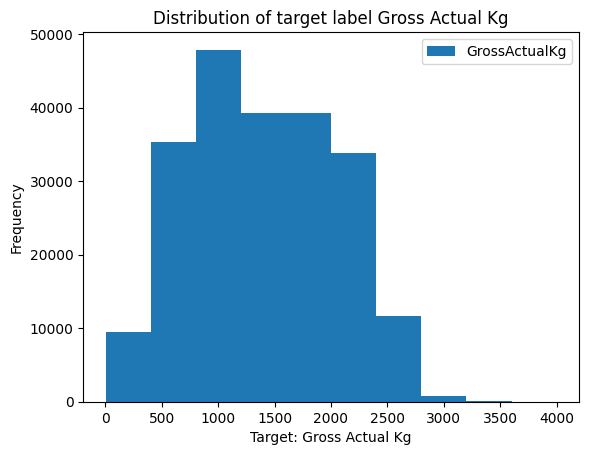

In [51]:
ax = df.plot(kind='hist', y=['GrossActualKg'])
ax.set_xlabel('Target: Gross Actual Kg')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of target label Gross Actual Kg')
plt.show()

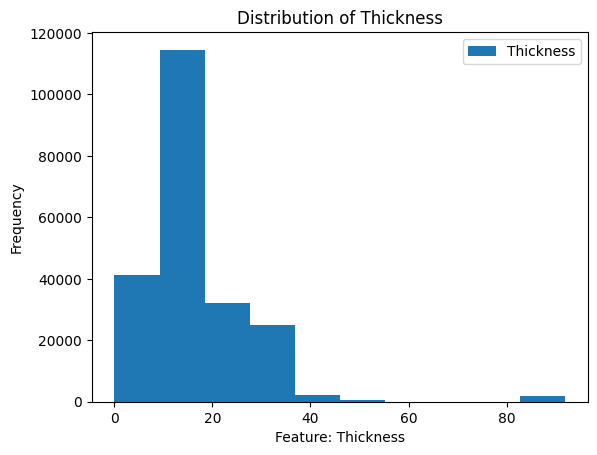

In [45]:
ax = df.plot(kind='hist', y=['Thickness'])
ax.set_xlabel('Feature: Thickness')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Thickness')
plt.show()

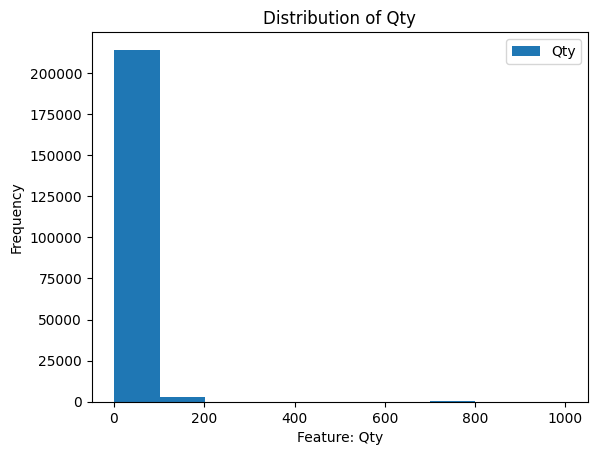

In [48]:
ax = df.plot(kind='hist', y=['Qty'])
ax.set_xlabel('Feature: Qty')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Qty')
plt.show()

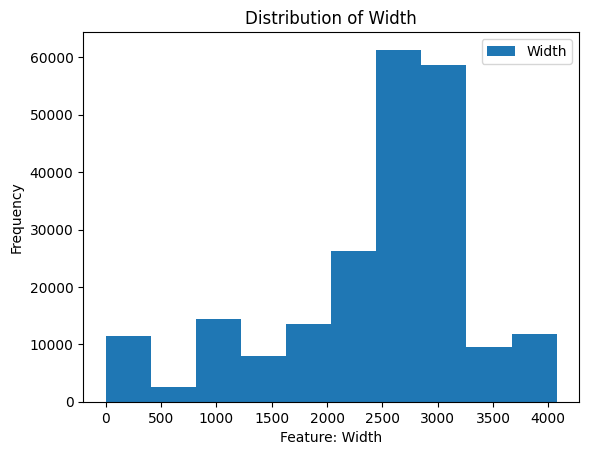

In [49]:
ax = df.plot(kind='hist', y=['Width'])
ax.set_xlabel('Feature: Width')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Width')
plt.show()

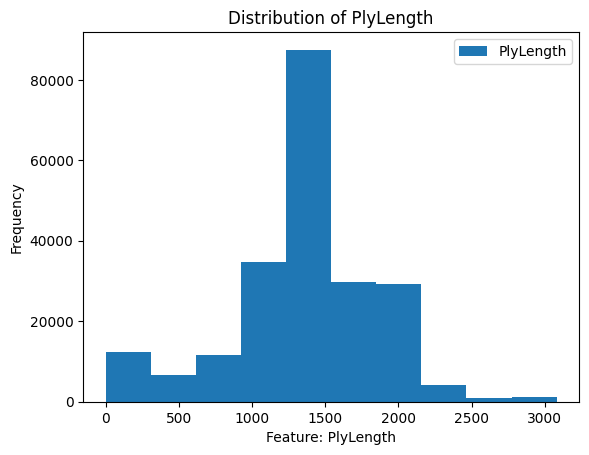

In [50]:
ax = df.plot(kind='hist', y=['PlyLength'])
ax.set_xlabel('Feature: PlyLength')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of PlyLength')
plt.show()

### Feature count before and after encoding

In [15]:
print(f"Shape of the small dataset: {X_s.shape}")
print(f"Shape of the large dataset: {X.shape}")

Shape of the small dataset: (45721, 39)
Shape of the large dataset: (217720, 39)


In [16]:
X_s_transformed = col_transformer.fit_transform(X_s)
print(f"Shape of the small transformed dataset: {X_s_transformed.shape}")

X_transformed = col_transformer.fit_transform(X)
print(f"Shape of the large transformed dataset: {X_transformed.shape}")

Shape of the small transformed dataset: (45721, 1559)
Shape of the large transformed dataset: (217720, 3047)


### Most important 50 features after encoding (LinearRegression)

In [23]:
X_s_transformed = col_transformer.fit_transform(X_s)
X_s_transformed_df = pd.DataFrame(X_s_transformed, columns=col_transformer.get_feature_names_out())

feature_extractor_model = LinearRegression()
extractor = SelectFromModel(feature_extractor_model, max_features=50)

In [24]:
X_s_transformed_df.head()

,standardscaler__MonthNum,standardscaler__Qty,standardscaler__Width,standardscaler__PlyLength,standardscaler__Thickness,onehotencoder__ItemLastMill_F,onehotencoder__ItemLastMill_H,onehotencoder__ItemLastMill_L,onehotencoder__ItemLastMill_T,onehotencoder__ItemLastMill_V,...,onehotencoder__CustomerAccount_D006586,onehotencoder__CustomerAccount_D006596,onehotencoder__CustomerAccount_D006598,onehotencoder__CustomerAccount_D006600,onehotencoder__CustomerAccount_D006603,onehotencoder__CustomerAccount_D006616,onehotencoder__CustomerAccount_D006623,onehotencoder__CustomerAccount_D006637,onehotencoder__CustomerAccount_D006652,onehotencoder__CustomerAccount_DD000008
0,-1.60552,-0.888799,0.737793,0.244074,0.038748,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-1.60552,-0.024607,0.164610,0.244074,0.038748,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-1.60552,-0.204647,0.164610,0.244074,0.332264,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-1.60552,-0.492711,0.164610,0.244074,0.038748,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-1.60552,-0.924807,0.164610,0.244074,0.038748,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
extractor.fit(X_s_transformed, y_s)

SelectFromModel(estimator=LinearRegression(), max_features=50)

In [26]:
mask = extractor.get_support()
print (X_s_transformed_df.columns[mask])

Index(['onehotencoder__ItemLastMill_L', 'onehotencoder__ItemLastMill_T',
       'onehotencoder__PackingType_VB00SP',
       'onehotencoder__PackingType_VSB0VP',
       'onehotencoder__PackingType_VSB0VP15',
       'onehotencoder__PackingType_VSBRVP',
       'onehotencoder__PackingType_VTB0VP15',
       'onehotencoder__PackingType_VTB1VP',
       'onehotencoder__PackingType_VTB2CP',
       'onehotencoder__PackingType_VTBP0P15', 'onehotencoder__Construction_-',
       'onehotencoder__Construction_10_(8-pls)',
       'onehotencoder__Construction_12_(9-pls)',
       'onehotencoder__Construction_12_spec-1',
       'onehotencoder__Construction_12_spec-12',
       'onehotencoder__Construction_14_(10-pls)',
       'onehotencoder__Construction_15_spec-12',
       'onehotencoder__Construction_16_(12-pls)',
       'onehotencoder__Construction_16_spec-1',
       'onehotencoder__Construction_18_spec-12',
       'onehotencoder__Construction_19_(14-pls)',
       'onehotencoder__Construction_21_spec-1

### Most important 50 features after encoding (DecisionTreeRegressor)

In [29]:
X_s_transformed = col_transformer.fit_transform(X_s)
X_s_transformed_df = pd.DataFrame(X_s_transformed, columns=col_transformer.get_feature_names_out())

feature_extractor_model = DecisionTreeRegressor(random_state=17)
extractor = SelectFromModel(feature_extractor_model, max_features=50)
extractor.fit(X_s_transformed, y_s)
mask = extractor.get_support()
print (X_s_transformed_df.columns[mask])

Index(['standardscaler__MonthNum', 'standardscaler__Qty',
       'standardscaler__Width', 'standardscaler__PlyLength',
       'standardscaler__Thickness', 'onehotencoder__ItemLastMill_F',
       'onehotencoder__ItemLastMill_T', 'onehotencoder__PackingType_FTB0VX',
       'onehotencoder__PackingType_HB00VM15', 'onehotencoder__Drawing_-',
       'onehotencoder__Drawing_705087_A', 'onehotencoder__Drawing_TD00332_01',
       'onehotencoder__EdgeColor_d.br.',
       'onehotencoder__EdgeProc_Drawing long and short edges',
       'onehotencoder__FilmLogo_-/RW Logo',
       'onehotencoder__FilmLogo_-/Schmitz',
       'onehotencoder__FilmLogo_Ultibat Combi/Ultibat Combi',
       'onehotencoder__Machining_Y', 'onehotencoder__OverlayPress_Y',
       'onehotencoder__SpecReq_Fibo', 'onehotencoder__TradeMark_RIGA PRIME',
       'onehotencoder__CustomerAccount_-',
       'onehotencoder__CustomerAccount_D000004',
       'onehotencoder__CustomerAccount_D000412',
       'onehotencoder__CustomerAccount_D

### Most important featues (permutation_importance)

In [30]:
pipe = Pipeline([
    ('transformer', col_transformer),
    ('model', DecisionTreeRegressor(random_state=17))
])

pipe.fit(X_s_train, y_s_train)


Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('standardscaler',
                                                  StandardScaler(),
                                                  ['MonthNum', 'Qty', 'Width',
                                                   'PlyLength', 'Thickness']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore',
                                                                sparse_output=False),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x00000146A5BCAA80>)])),
                ('model', DecisionTreeRegressor(random_state=17))])

In [31]:
score_r2 = r2_score(pipe.predict(X_s_test), y_s_test)
score_mse = mean_squared_error(pipe.predict(X_s_test), y_s_test)

print(score_r2)
print(score_mse)

0.9843037211519129
4538.806007810967


In [32]:
importance = permutation_importance(pipe, X_s_test, y_s_test, n_repeats=10)
feature_importance_df = pd.DataFrame({
    'feature': X_s.columns,
    'importance': importance.importances_mean,
    'std': importance.importances_std
}).sort_values('importance', ascending=False)

In [33]:
feature_importance_df

,feature,importance,std
35,Qty,1.484551e+00,1.001173e-02
37,Width,1.172085e+00,1.122038e-02
38,PlyLength,8.852117e-01,9.242860e-03
36,Thickness,6.334036e-01,8.373397e-03
1,PackingType,3.205605e-02,1.297538e-03
5,Drawing,2.812692e-02,1.562436e-03
33,CustomerAccount,1.492418e-02,5.732899e-04
27,PlyGrade,1.209513e-02,6.835376e-04
0,ItemLastMill,1.142833e-02,6.624233e-04
29,TradeMark,1.134919e-02,9.241202e-04
